#### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#### Read data

In [2]:
df = pd.read_csv('./../../data/vais_labeled.csv')
df.head()

,query,label,rank
0,"ACI Worldwide, Inc. Sustainability Report 2023...",0.0,1
1,"ACI Worldwide, Inc. Sustainability Report 2023...",1.0,2
2,"ACI Worldwide, Inc. Sustainability Report 2023...",0.0,3
3,"ACI Worldwide, Inc. Sustainability Report 2023...",0.0,4
4,"ACI Worldwide, Inc. Sustainability Report 2023...",0.0,5


In [3]:
df.count()

query    1000
label    1000
rank     1000
dtype: int64

#### Compute Precision@k

In [4]:
def precision_at_k(labels, k):
    return sum(labels[:k]) / k

Initialize dictionaries to store the precision at k for each query

In [5]:
precision_at_1 = {}
precision_at_3 = {}
precision_at_5 = {}
precision_at_10 = {}

Group by query and calculate precision at k for each group

In [6]:
for query, group in df.groupby('query'):
    labels = group.sort_values(by='rank')['label'].values
    precision_at_1[query] = precision_at_k(labels, 1)
    precision_at_3[query] = precision_at_k(labels, 3)
    precision_at_5[query] = precision_at_k(labels, 5)
    precision_at_10[query] = precision_at_k(labels, 10)

Calculate the mean precision at k

In [7]:
mean_precision_at_1 = sum(precision_at_1.values()) / len(precision_at_1)
mean_precision_at_3 = sum(precision_at_3.values()) / len(precision_at_3)
mean_precision_at_5 = sum(precision_at_5.values()) / len(precision_at_5)
mean_precision_at_10 = sum(precision_at_10.values()) / len(precision_at_10)

Compile the results into a DataFrame for display

In [8]:

scores = pd.DataFrame({
    'Precision@1': [mean_precision_at_1],
    'Precision@3': [mean_precision_at_3],
    'Precision@5': [mean_precision_at_5],
    'Precision@10': [mean_precision_at_10]
})

In [9]:
scores 

,Precision@1,Precision@3,Precision@5,Precision@10
0,0.1,0.06,0.046,0.05


#### Compute NDCG@k

In [10]:
def dcg_at_k(labels, k):
    return sum((2**labels[:k] - 1) / np.log2(np.arange(1, k + 1) + 1))

In [11]:
def idcg_at_k(labels, k):
    ideal_labels = sorted(labels, reverse=True)
    ideal_labels = np.array(ideal_labels)
    return dcg_at_k(ideal_labels, k)

Initialize dictionaries to store the nDCG at k for each query

In [12]:
ndcg_at_1 = {}
ndcg_at_3 = {}
ndcg_at_5 = {}
ndcg_at_10 = {}

Group by query and calculate nDCG at k for each group

In [13]:
for query, group in df.groupby('query'):
    labels = group.sort_values(by='rank')['label'].values
    dcg_1 = dcg_at_k(labels, 1)
    dcg_3 = dcg_at_k(labels, 3)
    dcg_5 = dcg_at_k(labels, 5)
    dcg_10 = dcg_at_k(labels, 10)
    
    idcg_1 = idcg_at_k(labels, 1)
    idcg_3 = idcg_at_k(labels, 3)
    idcg_5 = idcg_at_k(labels, 5)
    idcg_10 = idcg_at_k(labels, 10)
    
    ndcg_at_1[query] = dcg_1 / idcg_1 if idcg_1 > 0 else 0
    ndcg_at_3[query] = dcg_3 / idcg_3 if idcg_3 > 0 else 0
    ndcg_at_5[query] = dcg_5 / idcg_5 if idcg_5 > 0 else 0
    ndcg_at_10[query] = dcg_10 / idcg_10 if idcg_10 > 0 else 0

Calculate the mean nDCG at k

In [14]:
mean_ndcg_at_1 = sum(ndcg_at_1.values()) / len(ndcg_at_1)
mean_ndcg_at_3 = sum(ndcg_at_3.values()) / len(ndcg_at_3)
mean_ndcg_at_5 = sum(ndcg_at_5.values()) / len(ndcg_at_5)
mean_ndcg_at_10 = sum(ndcg_at_10.values()) / len(ndcg_at_10)

scores = pd.DataFrame({
    'nDCG@1': [mean_ndcg_at_1],
    'nDCG@3': [mean_ndcg_at_3],
    'nDCG@5': [mean_ndcg_at_5],
    'nDCG@10': [mean_ndcg_at_10]
})

scores

,nDCG@1,nDCG@3,nDCG@5,nDCG@10
0,0.1,0.140119,0.158841,0.228136


#### Compute MRR

In [15]:
reciprocal_ranks = []

Group by query and calculate the reciprocal rank for each group

In [16]:
for query, group in df.groupby('query'):
    group_sorted = group.sort_values(by='rank')
    first_relevant = group_sorted[group_sorted['label'] == 1].head(1)
    
    if not first_relevant.empty:
        rank = first_relevant['rank'].values[0]
        reciprocal_ranks.append(1 / rank)

Calculate the Mean Reciprocal Rank (MRR)

In [17]:
mrr = sum(reciprocal_ranks) / len(reciprocal_ranks)
pd.DataFrame({'MRR': [mrr]})

,MRR
0,0.408759


#### Compute MAP

In [18]:
def average_precision(labels):
    precisions = []
    num_relevant = 0
    for i, label in enumerate(labels):
        if label == 1:
            num_relevant += 1
            precisions.append(num_relevant / (i + 1))
    return sum(precisions) / num_relevant if num_relevant > 0 else 0

In [19]:
average_precisions = []

Group by query and calculate the average precision for each group

In [20]:
for query, group in df.groupby('query'):
    labels = group.sort_values(by='rank')['label'].values
    average_precisions.append(average_precision(labels))

Calculate the Mean Average Precision (MAP)

In [21]:
map_score = sum(average_precisions) / len(average_precisions)
pd.DataFrame({'MAP': [map_score]})

,MAP
0,0.167413


#### Visualize Results

In [22]:
# Data
metrics = ['Precision @1', 'Precision @3', 'Precision @5', 'Precision @10',
           'NDCG @1', 'NDCG @3', 'NDCG @5', 'NDCG @10', 'MRR', 'MAP']

vais_scores = [0.1, 0.06, 0.046, 0.05, 0.1, 0.140119, 0.158841, 0.228136, 0.408759, 0.167413]
serp_scores = [0.05, 0.043333, 0.052, 0.053, 0.05, 0.07934, 0.129856, 0.19849, 0.317063, 0.128952]


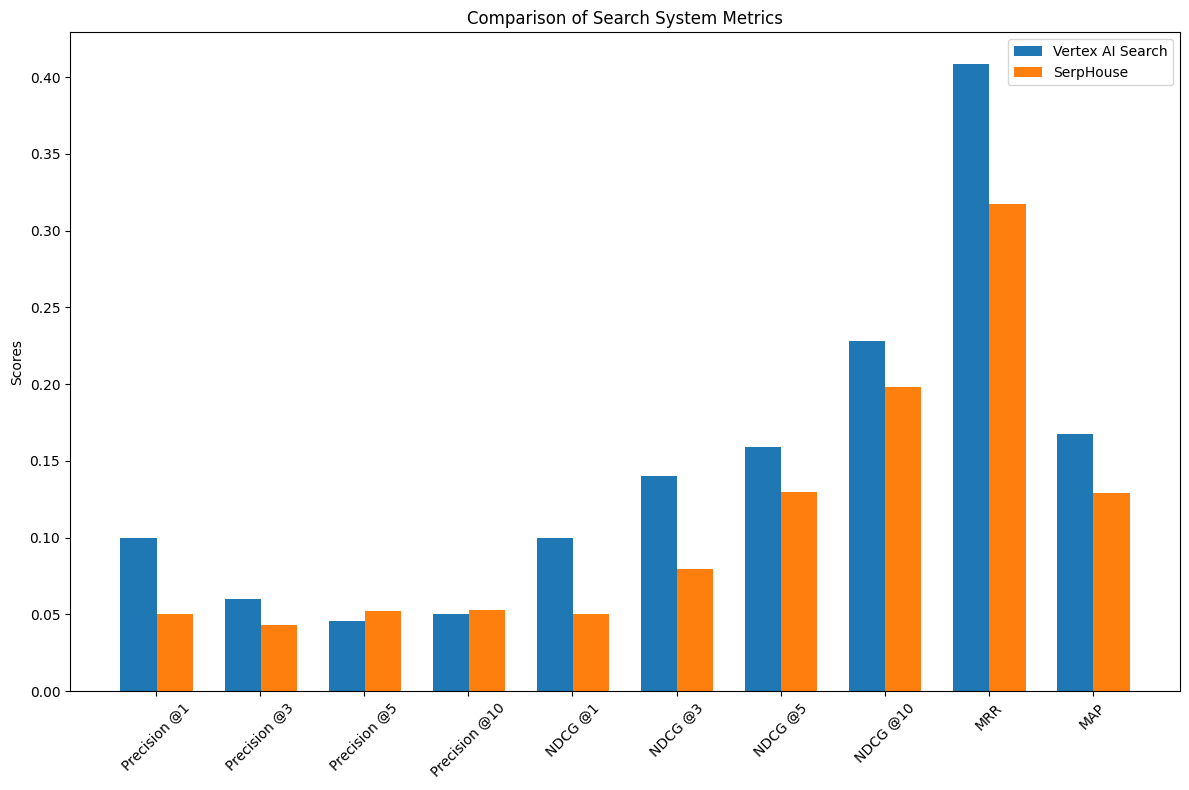

In [23]:
# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
x = range(len(metrics))
ax.bar(x, vais_scores, width=0.35, label='Vertex AI Search', align='center')
ax.bar([p + 0.35 for p in x], serp_scores, width=0.35, label='SerpHouse', align='center')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Search System Metrics')
ax.set_xticks([p + 0.17 for p in x])
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()